In [88]:
import os
import sys
import timeit
import random

import numpy as np

import theano
import theano.tensor as T

import matplotlib.pyplot as plt
import glob
import os.path as op
import pickle
from abc import ABCMeta, abstractmethod


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#mostly from stanford Deep NLP course source

class Corpus(object):
    
    __metaclass__ = ABCMeta
    #在Corpus主类中保存预料库的路径
    def __init__(self, corpusPath):
        self.corpusPath = corpusPath
    
    @abstractmethod
    def sentences(self):
        return None
    
    #分词方法
    def tokens(self):
        #判断自己是否有_tokens属性，若已经定义直接返回，否则需要用预料路径加载语料文件
        if hasattr(self, "_tokens") and self._tokens:
            return self._tokens
        print('--------')
        #语料字典
        tokens = dict()
        #字频繁度字典
        tokenfreq = dict()
        #单词个数
        wordcount = 0
        #不重复的单词列表
        revtokens = []
        
        idx = 0
        #调用sentences方法返回句子，该方法由子类实现
        for sentence in self.sentences():
            #遍历每个语料中的单词
            for w in sentence:
                #单词数加1
                wordcount += 1
                #单词不在语料字典中
                if not w in tokens:
                    #字作为键，idx作为该字的索引
                    tokens[w] = idx
                    #将该词加入不重复单词列表
                    revtokens += [w]
                    #该单词的频数加1
                    tokenfreq[w] = 1
                    #字典索引加1
                    idx += 1
                else:
                    #在语料字典中，则词频加1
                    tokenfreq[w] += 1
        #定义语料字典中的“UNK”为词典的最后一个索引。
        tokens["UNK"] = idx
        #不重复单词列表中增加“UNK”
        revtokens += ["UNK"]
        #“UNK”单词词频计数为1
        tokenfreq["UNK"] = 1
        #总词数加1
        wordcount += 1
        #把这些计算的值，赋值给类属性保存起来
        self._tokens = tokens
        self._tokenfreq = tokenfreq
        self._wordcount = wordcount
        self._revtokens = revtokens
        #返回语料字典tokens
        return self._tokens
    
    def numSentences(self):
        if hasattr(self, "_numSentences") and self._numSentences:
            return self._numSentences
        else:
            self._numSentences = len(self.sentences())
            return self._numSentences
        
    def getRandomContext(self, C=5):
        allsent = self.allSentences()
        sentID = random.randint(0, len(allsent) - 1)
        sent = allsent[sentID]
        wordID = random.randint(0, len(sent) - 1)

        context = sent[max(0, wordID - C):wordID] 
        if wordID+1 < len(sent):
            context += sent[wordID+1:min(len(sent), wordID + C + 1)]

        centerword = sent[wordID]
        context = [w for w in context if w != centerword]

        if len(context) > 0:
            return centerword, context
        else:
            return self.getRandomContext(C) 
        

        
    def allSentences(self):
        if hasattr(self, "_allsentences") and self._allsentences:
            return self._allsentences

        sentences = self.sentences()
        rejectProb = self.rejectProb()
        tokens = self.tokens()
        allsentences = [[w for w in s 
            if 0 >= rejectProb[tokens[w]] or random.random() >= rejectProb[tokens[w]]]
            for s in sentences * 30]

        allsentences = [s for s in allsentences if len(s) > 1]
        
        self._allsentences = allsentences
        
        return self._allsentences  

    
    def rejectProb(self):
        if hasattr(self, '_rejectProb') and self._rejectProb is not None:
            return self._rejectProb

        threshold = 1e-5 * self._wordcount

        nTokens = len(self.tokens())
        rejectProb = np.zeros((nTokens,))
        for i in range(nTokens):
            w = self._revtokens[i]
            freq = 1.0 * self._tokenfreq[w]
            # Reweigh
            rejectProb[i] = max(0, 1 - np.sqrt(threshold / freq))

        self._rejectProb = rejectProb
        return self._rejectProb    
    

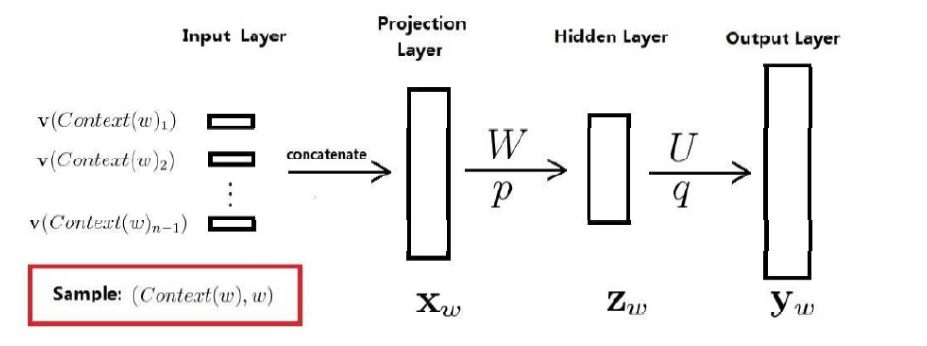

In [46]:
from IPython.display import Image
Image('net.png')

In [56]:
class Word2VecNet(object):
    
    __metaclass__ = ABCMeta
    #vector_size:词向量长度
    #vocabs_size:词典大小
    def __init__(self, vector_size, vocabs_size):
        #shape:vocabs_size * vector_size【词典大小*词向量大小】
        self.W_in_values = np.asarray((np.random.rand(vocabs_size, vector_size) - 0.5) / vector_size,dtype=theano.config.floatX)
        print('W_in_values shape:%s,type:%s'%(self.W_in_values.shape,type(self.W_in_values)))
        
        #shape:vocabs_size * vector_size【词典大小*词向量大小】
        self.W_out_values = np.asarray(np.zeros((vocabs_size, vector_size)),dtype=theano.config.floatX)   
        print('W_out_values shape:%s,type:%s'%(self.W_out_values.shape,type(self.W_out_values)))
        
        #Theano的shared类似于全局变量的概念,其值将会在多个函数中共用。
        self.W_in = theano.shared(
            value=self.W_in_values,
            name='W_in',
            borrow=True
        )
        
        self.W_out = theano.shared(
            value=self.W_out_values,
            name='W_out',
            borrow=True
        )  
        print('W_in:%s,W_out:%s'%(type(self.W_in),type(self.W_out)))

    
    @abstractmethod
    def cost_and_grad(self, win, wout):
        return None
    
    def save(slef, file_name):
        with open("{}.npy",format(file_name) , "w") as f:
            pickle.dump(self.W_in_values.shape, f)
            pickle.dump(self.W_in_values, f)       
            pickle.dump(self.W_out_values, f)
    
    
    def load(self, file_name):
        with open("{}.npy",format(file_name), "r") as f:
            _ = pickle.load(f)
            self.W_in_values[:] = pickle.load(f)
            self.W_out_values[:] = pickle.load(f)
    

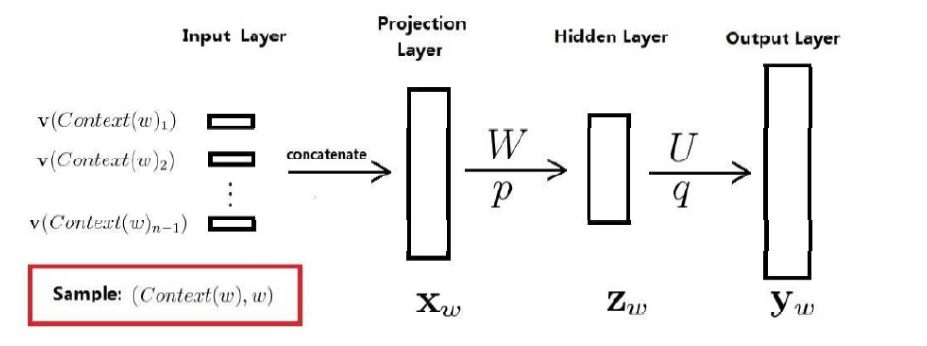

In [67]:
from IPython.display import Image
Image('net.png')

In [83]:
class Word2VecTrainer(object):
    
    __metaclass__ = ABCMeta
    #init方法接收定义好的网络参数对象和语料对象
    def __init__(self, w2v_net, corpus):
        
        self.w2v_net = w2v_net
        self.corpus = corpus
        self.tokens = corpus.tokens()
        #定义两个名为context和target的张量
        #type context:<class 'theano.tensor.var.TensorVariable'>
        #type target:<class 'theano.tensor.var.TensorVariable'>
        context = T.dvector('context')
        target = T.lscalar('target')
        print('type context:%s,type target:%s'%(type(context),type(target)))
        #function的第一个参数为输入列表，第二个参数为计算函数。这里调用计算损失和梯度的函数cost_and_grad
        self.train_model = theano.function([context, target], 
                                           self.w2v_net.cost_and_grad(context, target))
        
    
    #C：窗口大小, step：学习步长, iterations：迭代词数
    def train(self,
              window_size=5,
              learning_rate=0.3,
              iterations=5000,
              batch_size=50,
              #退火
              anneal_every=20000,
              print_every=10):
        
        print ('Start Training')
        
        start_it = 1
        #开始迭代
        for it in range(start_it, iterations + 1):
            #一个批次一个批次训练
            cost, grad_in, grad_out = self.train_one_batch(window_size, batch_size)
            print('cost:%s,\ngrad_in:%s,\ngrad_out:%s'%(cost,grad_in,grad_out))
            #更新w_in_values和w_out_values参数 ： 减去学习率乘以梯度值
            self.w2v_net.W_in_values -= learning_rate * grad_in
            self.w2v_net.W_out_values -= learning_rate * grad_out
            
            if it % 10 == 0:
                print ('Iteration:{}, Cost {}'.format(it, cost))
            #迭代次数达到了退火的迭代次数，学习率*.5，降低学习率
            if it % anneal_every == 0:
                learning_rate *= 0.5 
                
        return cost, grad_in, grad_out
    
        
    
    def train_one_batch(self, window_size, batch_size):
        cost = 0.0
        grad_in = np.zeros_like(self.w2v_net.W_in_values)
        grad_out = np.zeros_like(self.w2v_net.W_out_values)
        
        for i in range(batch_size):
            c = random.randint(1, window_size)
            centerword, context = self.corpus.getRandomContext(c)
            c_cost, gin, gout = self.train_one_step(centerword, context)
            cost += c_cost / batch_size 
            grad_in += gin / batch_size
            grad_out += gout / batch_size
        
        return cost, grad_in, grad_out
    
    @abstractmethod
    def train_one_step(self, centerword, context):
        return None

        

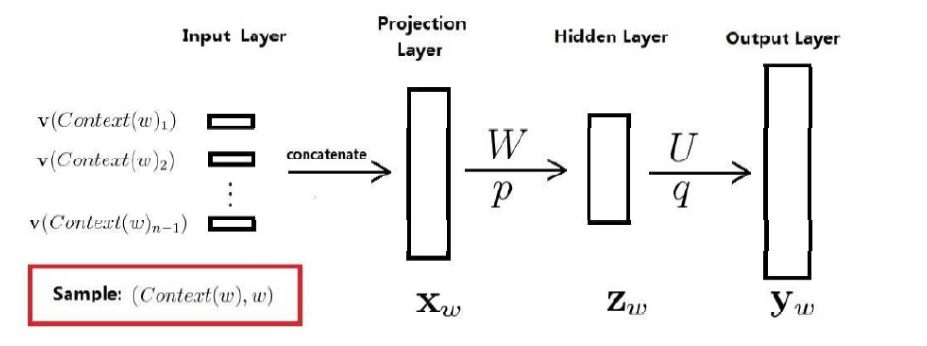

In [68]:
from IPython.display import Image
Image('net.png')

In [6]:
class CBOWTrainer(Word2VecTrainer):
    
    def train_one_step(self, centerword, context):
        
        cost = 0.
        
        grad_in = np.zeros_like(self.w2v_net.W_in_values)
        grad_out = np.zeros_like(self.w2v_net.W_out_values)
        
        target_word_index = self.tokens[centerword]
        
        for j in context:
            current_word_index = self.tokens[j]
            r = self.w2v_net.W_in_values[current_word_index]
            c_cost, c_grad_in, c_grad_out = self.train_model(r, target_word_index)
            cost += c_cost
            grad_out += c_grad_out 
            grad_in[current_word_index,:] += c_grad_in.flatten()      

        return cost    

In [84]:
class SkipGramTrainer(Word2VecTrainer):

    def train_one_step(self, centerword, context):
        
        cost = 0.
        
        grad_in = np.zeros_like(self.w2v_net.W_in_values)
        grad_out = np.zeros_like(self.w2v_net.W_out_values)
        
        target_word_index = self.tokens[centerword]
        r = self.w2v_net.W_in_values[target_word_index]
        
        for j in context:
            current_word_index = self.tokens[j]
            c_cost, c_grad_in, c_grad_out = self.train_model(r, current_word_index)
            cost += c_cost
            grad_out += c_grad_out 
            grad_in[current_word_index,:] += c_grad_in.flatten()
                   

        return cost, grad_in, grad_out     

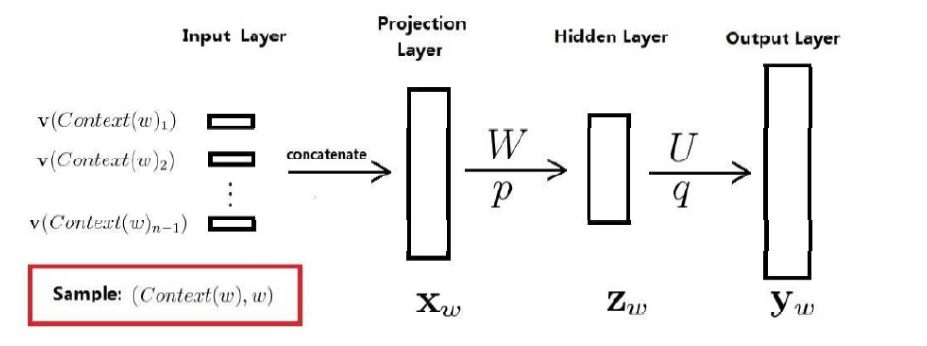

In [69]:
from IPython.display import Image
Image('net.png')

In [76]:
#经典的word2vec网络，继承自Word2VecNet类
class ClassicalWord2VecNet(Word2VecNet):
    #计算损失和梯度值参数为：        
    #type context:<class 'theano.tensor.var.TensorVariable'>
    #type target:<class 'theano.tensor.var.TensorVariable'>
    def cost_and_grad(self, win, wout):
        print("win:%s,wout:%s"%(type(win),type(wout)))
        print("win:%s,wout:%s"%(win.shape,wout.shape))
        #调用softmax分类函数，最后使用dimshuffle将结果行变成列，列变成行【转置】
        p_wout_given_win = T.nnet.softmax(T.dot(win, self.W_out.T)).dimshuffle(1, 0)
        print("p_wout_given_win:",p_wout_given_win.shape,type(p_wout_given_win))
        #求对数损失值
        cost = -T.log(p_wout_given_win[wout])
        
        foo = T.zeros_like(p_wout_given_win)
        T.set_subtensor(foo[wout], 1)
        z = p_wout_given_win - foo
        #梯度计算
        grad_in = T.dot(self.W_out.T, z)
        grad_out = T.outer(z, win)
        #返回损失值和梯度值
        return cost, grad_in, grad_out


In [18]:
class StanfordSentimentCorpus(Corpus):
    #调用父类的init方法，加载语料库
    def __init__(self):
        super(StanfordSentimentCorpus, self).__init__('./datasets/stanfordSentimentTreebank/datasetSentences.txt')
    
    def sentences(self):
        #判断是否已经加载了语料中的句子，有就直接返回，否则加载语料文件
        if hasattr(self, "_sentences") and self._sentences:
            return self._sentences
        #句子列表
        sentences = []
        #打开文件
        with open(self.corpusPath, "r") as f:
            #遍历f文件中的每一行数据
            first = True
            for line in f:
                if first:
                    #略过第一行
                    first = False
                    continue
                #忽略行标号    
                splitted = line.strip().split()[1:]
                # Deal with some peculiar encoding issues with this file : latin1
                #处理数据全部设置为小写，编码改为utf-8
                sentences += [[w.lower().encode('utf-8') for w in splitted]]
        #将分割出来的词作为类属性        
        self._sentences = sentences
        #记录每个句子中单词的个数，即长度
        self._sentlengths = np.array([len(s) for s in sentences])
        print('每个句子的长度:',self._sentlengths)
        #记录分步叠加的单词数
        self._cumsentlen = np.cumsum(self._sentlengths)
        print('句子分步累加长:',self._cumsentlen)
        return self._sentences        

In [86]:
random.seed(314)
corpus = StanfordSentimentCorpus()
vocabs_size = len(corpus.tokens())
print('词典大小：',vocabs_size)
# 定义词向量的长度为10
vector_size = 10
# 定义上下文的语境长度为5
C = 5
#迭代词数100次
iterations = 10
#学习步长为0.3
step = 0.3


--------
每个句子的长度: [36 37  4 ..., 23 32  5]
句子分步累加长: [    36     73     77 ..., 227205 227237 227242]
词典大小： 19539


In [87]:
random.seed(123)
np.random.seed(123)
w2vecNet = ClassicalWord2VecNet(vector_size, vocabs_size)
trainer = SkipGramTrainer(w2vecNet, corpus)
#trainer = CBOWTrainer(w2vecNet,corpus)
cost,grad_in,grad_out = trainer.train(C, step, iterations)
print("----->cost:{}\ngrad_in:{}\ngrad_out:{}".format(cost,grad_in,grad_out))

W_in_values shape:(19539, 10),type:<class 'numpy.ndarray'>
W_out_values shape:(19539, 10),type:<class 'numpy.ndarray'>
W_in:<class 'theano.tensor.sharedvar.TensorSharedVariable'>,W_out:<class 'theano.tensor.sharedvar.TensorSharedVariable'>
type context:<class 'theano.tensor.var.TensorVariable'>,type target:<class 'theano.tensor.var.TensorVariable'>
win:<class 'theano.tensor.var.TensorVariable'>,wout:<class 'theano.tensor.var.TensorVariable'>
win:Shape.0,wout:Shape.0
p_wout_given_win: Shape.0 <class 'theano.tensor.var.TensorVariable'>
Start Training


D:\softwares\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.


cost:[ 26.08364285],
grad_in:[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]],
grad_out:[[  4.96224966e-07  -1.01498162e-06   2.02844549e-07 ...,  -3.12880742e-07
   -4.27581720e-07  -1.11284221e-06]
 [  4.96224966e-07  -1.01498162e-06   2.02844549e-07 ...,  -3.12880742e-07
   -4.27581720e-07  -1.11284221e-06]
 [  4.96224966e-07  -1.01498162e-06   2.02844549e-07 ...,  -3.12880742e-07
   -4.27581720e-07  -1.11284221e-06]
 ..., 
 [  4.96224966e-07  -1.01498162e-06   2.02844549e-07 ...,  -3.12880742e-07
   -4.27581720e-07  -1.11284221e-06]
 [  4.96224966e-07  -1.01498162e-06   2.02844549e-07 ...,  -3.12880742e-07
   -4.27581720e-07  -1.11284221e-06]
 [  4.96224966e-07  -1.01498162e-06   2.02844549e-07 ...,  -3.12880742e-07
   -4.27581720e-07  -1.11284221e-06]]
cost:[ 28.0596764],
grad_in:[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0

(-0.060717171594955814, 0.057297754078144421)

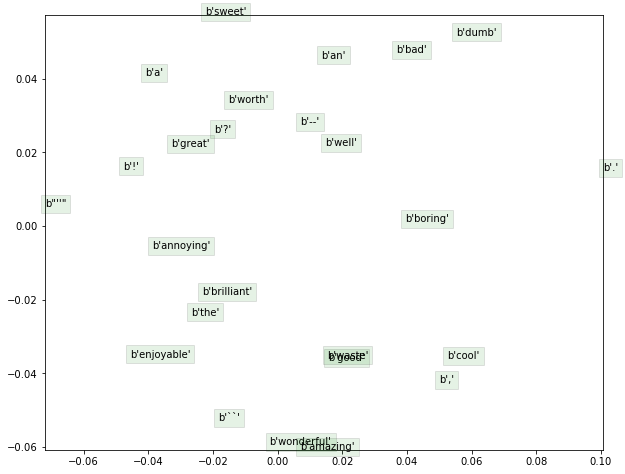

In [25]:
# Visualize the word vectors you trained

tokens = corpus.tokens()
wordVectors = (w2vecNet.W_in_values + w2vecNet.W_out_values)
visualizeWords = [b"the", b"a", b"an", b",", b".", b"?", b"!", b"``", b"''", b"--", b"good", b"great", b"cool", b"brilliant", b"wonderful", b"well", b"amazing", b"worth", b"sweet", b"enjoyable", b"boring", b"bad", b"waste", b"dumb", b"annoying"]
visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2]) 

for i in range(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i], bbox=dict(facecolor='green', alpha=0.1))
    
plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))